In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from tensorflow import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping
np.random.seed(42)
tf.random.set_seed(42)


mpl.rcParams['figure.figsize'] = (20, 18)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
data = pd.read_csv("/content/gdrive/My Drive/Thesis/dataframe_flow_variable_60min.csv")
data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
data.rename( columns={'Unnamed: 0':'Date_time','225':'DMA_225'}, inplace=True )

data_DMA225 = data[['Date_time','DMA_225','tempC','HeatIndexC','FeelsLikeC','WindChillC','windspeedKmph','sunHour','precipMM','humidity']]
data_DMA225_indexed = data_DMA225.set_index('Date_time')

# Making hourly data 
hourly_data = data_DMA225_indexed.resample('h').sum()
hourly_data.isnull().sum().sum()
hourly_data.isna().sum().sum()

#Scaling the data 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(hourly_data)

#Feature, Target dataset // 24 hour prediction
# feature_variable- last 24 hours columns and readings are removed
# target_variable- first 24 hours dma_225 columns and readings are removed

feature_variable = scaled_data[:][:-24] 
target_variable = scaled_data[:, 0][24:] 

In [4]:
feature_variable.shape

(2184, 9)

In [5]:
target_variable.shape

(2184,)

In [6]:
#Train-Test Split:
train_X, test_X, train_y, test_y = train_test_split(feature_variable, target_variable, test_size=0.40, random_state=123, shuffle = False)

# Create window of lagged variables
timesteps = 12
batch_size=32
train_generator = TimeseriesGenerator(train_X, train_y, length=timesteps, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(test_X, test_y, length=timesteps, sampling_rate=1, batch_size=batch_size)

In [7]:
model = keras.models.Sequential([
keras.layers.LSTM(100,return_sequences=True, input_shape=(12,9)),
keras.layers.ReLU(0.4),
#keras.layers.Dropout(0.1),
#keras.layers.LSTM(100,return_sequences=True,),
#keras.layers.LeakyReLU(0.5),
#keras.layers.Dropout(0.30),
keras.layers.LSTM(75,return_sequences=False),
#keras.layers.LeakyReLU(0.5),
keras.layers.Dropout(0.35),
keras.layers.Dense(70),
keras.layers.Dropout(0.45),
keras.layers.Dense(1)
])
#opt=keras.optimizers.Adam(learning_rate=0.0001,decay=0.1)
model.compile(loss='mae', optimizer='adam'),
history = model.fit(train_generator, epochs=65, validation_data=test_generator,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)],shuffle=False)
                    

Epoch 1/65
41/41 [==============================] - 6s 67ms/step - loss: 0.2248 - val_loss: 0.1472
Epoch 2/65
41/41 [==============================] - 1s 29ms/step - loss: 0.1502 - val_loss: 0.1401
Epoch 3/65
41/41 [==============================] - 1s 30ms/step - loss: 0.1407 - val_loss: 0.0981
Epoch 4/65
41/41 [==============================] - 1s 29ms/step - loss: 0.1205 - val_loss: 0.1190
Epoch 5/65
41/41 [==============================] - 1s 28ms/step - loss: 0.1146 - val_loss: 0.0909
Epoch 6/65
41/41 [==============================] - 1s 29ms/step - loss: 0.1035 - val_loss: 0.1086
Epoch 7/65
41/41 [==============================] - 1s 28ms/step - loss: 0.0999 - val_loss: 0.1162
Epoch 8/65
41/41 [==============================] - 1s 28ms/step - loss: 0.0996 - val_loss: 0.0950
Epoch 9/65
41/41 [==============================] - 1s 28ms/step - loss: 0.0923 - val_loss: 0.0862
Epoch 10/65
41/41 [==============================] - 1s 29ms/step - loss: 0.0886 - val_loss: 0.0926
Epoch 11/

In [8]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

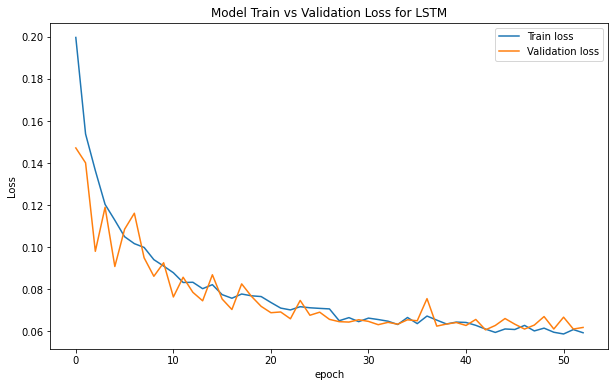

In [9]:
plot_loss(history,'LSTM')

In [10]:
#evaluation = model.evaluate(x=X_test, y=y_test, verbose=1)
test_pred = model.evaluate(test_generator)
forecast = model.predict(test_generator)
forecast.shape

27/27 [==============================] - 0s 7ms/step - loss: 0.0619


(862, 1)

In [11]:
test_X[:,1][12:].shape

(862,)

In [12]:
test_X[:,1:][12:].shape

(862, 8)

In [13]:
test_X[:,0][12:].shape

(862,)

In [14]:
test_X[:,0:][12:].shape

(862, 9)

In [15]:
# To make a dataframe of original and predicted value:
lstm_df=[]
for i in range (0, len(forecast)):
  lstm_df.append((forecast[i][0]))
final_df = pd.DataFrame((test_X[:,1][12:]))
final_df.rename(columns = {0:'original_value'}, inplace = True)
final_df['predicted_value'] = lstm_df

In [16]:
import math
from sklearn.metrics import mean_squared_error
#testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
testset = math.sqrt(mean_squared_error(final_df['original_value'], final_df['predicted_value']))
print("The RMSE prediction value on testset: ",testset)

The RMSE prediction value on testset:  0.35374448630938315


In [17]:
forecast_df=pd.concat([pd.DataFrame(forecast), pd.DataFrame(test_X[:,1:][12:])],axis=1)
inverse_transform=scaler.inverse_transform(forecast_df)
abc=inverse_transform[:,0]
DMA_225_final=hourly_data[forecast.shape[0]*-1:]
DMA_225_final['DMA_225_forecast']=abc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



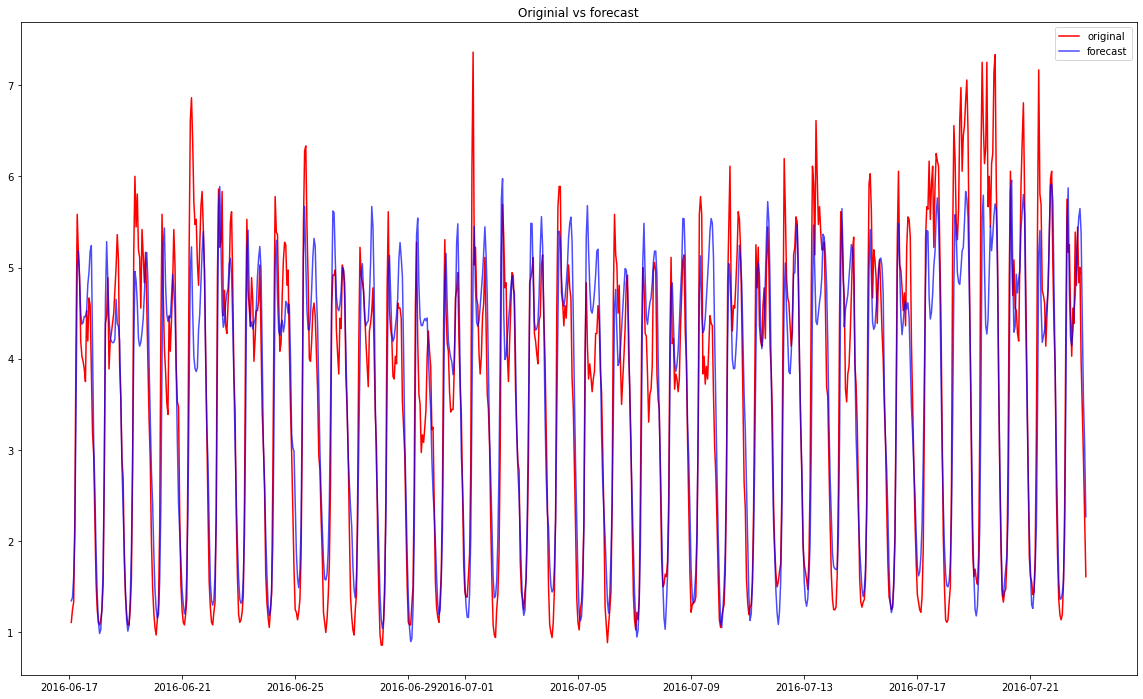

In [18]:
result_df = DMA_225_final.reset_index()
# Plotting original and predicted graph:
plt.figure(figsize=(20, 12))
plt.plot(result_df.Date_time, result_df.DMA_225, color='red', label='original')
plt.plot(result_df.Date_time, result_df.DMA_225_forecast, color='blue', label='forecast', alpha=0.7)
plt.title('Originial vs forecast')
plt.legend()
plt.show()

In [19]:
result_df.head(10)

,Date_time,DMA_225,tempC,HeatIndexC,FeelsLikeC,WindChillC,windspeedKmph,sunHour,precipMM,humidity,DMA_225_forecast
0,2016-06-17 02:00:00,1.11100,10,10,8,8,9,12.8,0.0,98,1.347017
1,2016-06-17 03:00:00,1.24975,10,10,8,8,10,12.8,0.0,98,1.382555
2,2016-06-17 04:00:00,1.33300,10,10,9,9,10,12.8,0.0,97,1.601994
3,2016-06-17 05:00:00,2.25000,11,11,10,10,10,12.8,0.0,95,2.073320
4,2016-06-17 06:00:00,4.19475,12,12,11,11,10,12.8,0.0,94,3.426398
5,2016-06-17 07:00:00,5.58325,12,12,11,11,11,12.8,0.0,93,4.991664
6,2016-06-17 08:00:00,5.16675,12,12,11,11,12,12.8,0.0,92,5.181305
7,2016-06-17 09:00:00,4.91675,12,12,11,11,14,12.8,0.0,91,4.866762
8,2016-06-17 10:00:00,4.19425,13,13,12,12,13,12.8,0.0,87,4.501455
9,2016-06-17 11:00:00,4.02775,13,13,12,12,13,12.8,0.0,84,4.379165


In [20]:
from google.colab import files

# e.g. save pandas output as csv
result_df.to_csv('DMA_225_MLSTM_tsg.csv')

# or any other file as usual
# with open('example.csv', 'w') as f:
#   f.write('your strings here')

files.download('DMA_225_MLSTM_tsg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>